## Exploratory analysis of the MM-WHS dataset

In [1]:
# imports 
import numpy as np
import os
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
    SpatialPadd,
)

import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk
import random

# Example MR dataset

In [2]:
data_dir = "../MMWHS_Dataset/mr_train"
images = sorted(glob.glob(os.path.join(data_dir, "mr_train_1001_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "mr_train_1001_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))

1


In [103]:
all_images = sorted(glob.glob(os.path.join(data_dir, "mr_train_*_image.nii.gz")))
random.shuffle(all_images)
train_images = all_images[:16]
len(train_images)
val_images = all_images[16:18]
len(val_images)
test_images = all_images[18:]
len(test_images)
print(train_images)
print(val_images)
print(test_images)

['../MMWHS_Dataset/mr_train/mr_train_1001_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1014_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1003_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1006_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1012_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1020_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1005_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1017_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1018_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1002_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1019_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1010_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1016_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1009_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1015_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1011_image.nii.gz']
['../MMWHS_Dataset/mr_train/mr_train_1008_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1013_image

In [3]:
volume_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"), # normalization between 0 and 1
        EnsureTyped(keys=["img", "seg"]),
    ]
)

In [4]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:23<00:00, 23.73s/it]


In [106]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)

middle_image = check_data["img"][0, :, :, :, 70]
middle_label = check_data["seg"][0, :, :, :, 70]
print("image shape", middle_image.shape, "label shape", middle_label.shape)

first volume's shape torch.Size([1, 1, 288, 288, 160]) torch.Size([1, 1, 288, 288, 160])
image shape torch.Size([1, 288, 288]) label shape torch.Size([1, 288, 288])


In [10]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, 1, None),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=0),  # squeeze the last dim
        #Resized(keys=["img", "seg"], spatial_size=[512, 1, 512]),
        #SpatialPadd(keys=["img", "seg"], spatial_size=[256, 1, 256]),
        MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850], target_labels=[1, 2, 3, 4, 5 , 6 , 7]),
    ]
)

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [15]:
i = 0
current_directory = os.getcwd()
output_dir_image = "preprocessed/mr_examples/images"
output_dir_label = "preprocessed/mr_examples/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)
j = 0
for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    j += 1
    if j > 265:
        image = image.squeeze(2)
        label = label.squeeze(2)
        print(image.shape)
        print(label.shape)
        # Convert the torch tensor to a SimpleITK image
        slice_image = sitk.GetImageFromArray(image)
        slice_label = sitk.GetImageFromArray(label)
        # # Save the 2D slice as a NIfTI file
        sitk.WriteImage(slice_image, os.path.join(output_dir_image, f"axial_pad.nii.gz"))
        sitk.WriteImage(slice_label, os.path.join(output_dir_label, f"axial_pad.nii.gz"))
        
        break

print("Total number of slices:", j)

    

torch.Size([1, 512, 160])
torch.Size([1, 512, 160])
Total number of slices: 266


In [16]:
filename = "preprocessed/mr_examples/images/axial_pad.nii.gz"
example_im = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename).squeeze(0).squeeze(0)
print(f"image data shape: {example_im.shape}")

filename = "preprocessed/mr_examples/labels/axial_pad.nii.gz"
example_label = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename).squeeze(0).squeeze(0)
print(f"label data shape: {example_label.shape}")

image data shape: torch.Size([160, 512, 1])
label data shape: torch.Size([160, 512, 1])


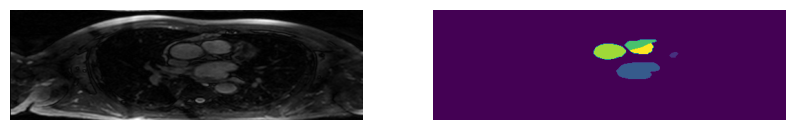

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label)
